In [1]:
import torch
import gradio as gr
import importlib
import loaders
import functools
import edit
import importlib
import taming.modules.vqvae.quantize
importlib.reload( taming.modules.vqvae.quantize)
importlib.reload(loaders)
from loaders import load_default

model = load_default()

/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [5]:
bp = functools.partial(edit.blend_paths, model, show=False)
lip_vector = torch.load("./latent_vectors/lipvector.pt")


In [6]:
# import torch
# torch.save(gender_vector, "./latent_vectors/gender.pt")

NameError: name 'gender_vector' is not defined

In [4]:
from img_processing import custom_to_pil
import edit
importlib.reload(edit)
from edit import blend_paths
class ImageState:
    def __init__(self, model) -> None:
        self.model = model
        #latentvectors
        self.lip_vector = torch.load("./latent_vectors/lipvector.pt")
        self.red_blue_vector = torch.load("./latent_vectors/red_blue.pt")
        self.green_purple_vector = torch.load("./latent_vectors/green_purple.pt")
        self.gender_vector = torch.load("./latent_vectors/gender.pt")
        #latent transforms
        self.hair_rb = torch.zeros_like(self.lip_vector)
        self.lip_transforms = torch.zeros_like(self.lip_vector)
        self.gender_transforms = torch.zeros_like(self.lip_vector)
        self.hair_gp = torch.zeros_like(self.lip_vector)
        self.blend_latent = None
        self.quant = True
    def _apply_vector(self, src, vector):
        new_latent = torch.lerp(src, src + vector, 1)
        return new_latent
    # def _get_decoded_current_latent(self):
        # self.current_im = self.model.decode(self.blend_latent.to("mps"))[0]
        # return custom_to_pil(self.current_im)
    def _decode_latent(self, latent):
        current_im = self.model.decode(latent.to("mps"))[0]
        return custom_to_pil(current_im)
    def _render_all_transformations(self):
        self.current_vector_transforms = [self.hair_rb, self.lip_transforms, self.hair_gp, self.gender_transforms]
        new_latent = torch.lerp(self.blend_latent, self.blend_latent + sum(self.current_vector_transforms), 1)
        if self.quant:
            new_latent, _, _ = self.model.quantize(new_latent.to("mps"))
        return self._decode_latent(new_latent)
    def apply_gp_vector(self, weight):
        self.hair_gp = weight * self.green_purple_vector
        return self._render_all_transformations()
    def apply_rb_vector(self, weight):
        self.hair_rb = weight * self.red_blue_vector
        return self._render_all_transformations()
    def apply_lip_vector(self, weight):
        self.lip_transforms = weight * self.lip_vector
        return self._render_all_transformations()
    def update_requant(self, val):
        print(f"val = {val}")
        self.quant = val
        return self._render_all_transformations()
    def apply_gender_vector(self, weight):
        self.gender_transforms = weight * self.gender_vector
        return self._render_all_transformations()
    def blend(self, path1, path2, weight):
        img, latent = blend_paths(self.model, path1, path2, weight=weight, show=False)
        self.blend_latent = latent
        # if self.current_vector_transforms is not None:
        #     new_latent = self._apply_vector(self.blend_latent, self.current_vector_transforms)
        #     return self._decode_latent(new_latent)
            # return self._get_decoded_current_latent()
        return self._render_all_transformations()
        # else:
            # return img

/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


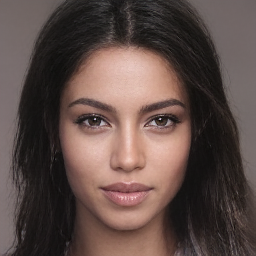

In [23]:
test = ImageState(model)
test.blend("./test_data/face.jpeg", "./test_data/face2.jpeg", 0.5)
test.apply_lip_vector(0.6)

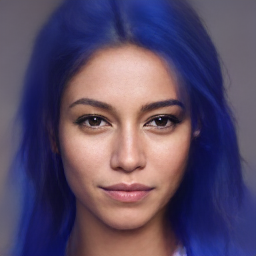

In [ ]:
test.apply_rb_vector(.8)

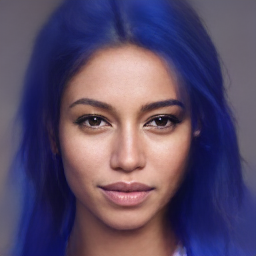

In [ ]:
test.apply_lip_vector(.6)

/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


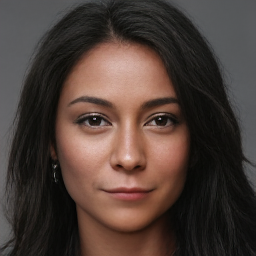

In [ ]:
test.blend("./test_data/face.jpeg", "./test_data/face2.jpeg", 0.1)

In [5]:
import functools
import edit
import importlib
importlib.reload(edit)
bp = functools.partial(edit.blend_paths, model, show=False)

state = ImageState(model)
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column(scale=2):
            hair_red_blue = gr.Slider(
                label="hair red<->blue ",
                minimum=-.8,
                maximum=.8,
                value=0,
                step=0.1,
            )
            hair_green_purple = gr.Slider(
                label="hair green<->purple ",
                minimum=-.8,
                maximum=.8,
                value=0,
                step=0.1,
            )
            lip_size = gr.Slider(
                label="lip size",
                minimum=-1.9,
                value=0,
                maximum=1.9,
                step=0.1,
            )
            blend_weight = gr.Slider(
                label="0 is src image, 1 is blend_img",
                minimum=-0.,
                value=0,
                maximum=1.,
                step=0.1,
            )
            requantize = gr.Checkbox(
                label="requantize latents",
            )
            gender_weight = gr.Slider(
                label="gender weight (-1 female, 1 male)",
                minimum=-2.,
                value=0,
                maximum=2.,
                step=0.07,
            )
            base_img = gr.Image(label="base Image", type="filepath")
            blend_img = gr.Image(label="image for face blending (optional)", type="filepath")

        with gr.Column(scale=1):
            out = gr.Image(interactive=False, shape=(200, 200))
            test = gr.Image(interactive=False, shape=(200, 200))
            i = gr.Button()
    gender_weight.change(state.apply_gender_vector, inputs=[gender_weight], outputs=out)
    requantize.change(state.update_requant, inputs=[requantize], outputs=out)
    lip_size.change(state.apply_lip_vector, inputs=[lip_size], outputs=out)
    hair_green_purple.change(state.apply_gp_vector, inputs=[hair_green_purple], outputs=out)
    hair_red_blue.change(state.apply_rb_vector, inputs=[hair_red_blue], outputs=out)
    blend_weight.change(state.blend, inputs=[base_img, blend_img, blend_weight], outputs=out)
    base_img.change(lambda x:x, inputs=base_img, outputs=out)
    blend_img.change(state.blend, inputs=[base_img, blend_img, blend_weight], outputs=out)


demo.launch(inbrowser=True)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/PIL/Image.py", line 3135, in open
    fp.seek(0)
AttributeError: 'NoneType' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/gradio/routes.py", line 292, in run_predict
    output = await app.blocks.process_api(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/gradio/blocks.py", line 1007, in process_api
    result = await self.call_function(fn_index, inputs, iterator, request)
  File "/opt

val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = False
val = True
val = False
val = True
val = False
val = True
val = False


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = True
val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = False
val = True
val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = False


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = True
val = False


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is

val = False
val = True
val = False
val = True
val = False
val = True
val = False
val = True
val = False


/opt/homebrew/Caskroom/miniforge/base/envs/taming/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
